# Music Analysis/Processing Experimental Notebook

This notebook aims to develop the song analysis and processing that will be used when downloading and analyzing songs and predicting beat maps from new songs.

In [1]:
import librosa
import librosa.display
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
def song_clusters(song_path):
    """This function performs an unsupervised clustering on a given song by computing a chromagram of the song, 
    dividing the song up into similar segments with the librosa.segment.agglomerative() function, then using a
    sklearn AgglomerativeClustering instance to secondarily cluster the similar segments into 7 clusters. Returns a 
    DataFrame with the segment time boundaries and the assigned cluster number. """
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    cluster_init = AgglomerativeClustering()
    bounds = librosa.segment.agglomerative(chromagram, k=1, clusterer = cluster_init)
    bound_times = librosa.frames_to_time(bounds, sr=sr)
    chromacluster = AgglomerativeClustering(n_clusters=7, affinity = 'euclidean', linkage = 'ward')
    chromacluster.fit(pd.DataFrame(librosa.util.sync(chromagram, bounds, aggregate=np.mean).T))
    clusters = pd.concat([pd.Series(bound_times), pd.Series(chromacluster.labels_)], axis = 1)
    return clusters

In [113]:
def clusters_by_beat(song_path):
    """Similar to song_clusters(), this function clusters beat frames together by their chroma similarity and 
    returns a DataFrame of beat frames with their assigned cluster number."""
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    beat_clusterer = AgglomerativeClustering(n_clusters=None, affinity = 'cosine', linkage='complete', distance_threshold=0.25)
    beat_clusterer.fit(pd.DataFrame(librosa.util.sync(chromagram, beat_frames, aggregate=np.mean).T))
    bclusters = pd.concat([pd.Series(beat_frames), pd.Series(beatcluster.labels_)], axis = 1)
    return bclusters 
    
    

In [161]:
def beat_and_chroma_features(song_path):
    """This function loads a song with the librosa package, computes the chromagram, and isolates the beat times.
    It then combines the beats and chroma features into a single DataFrame, indexed by beat frames. Returns both the
    estimated BPM and chroma feature DataFrame"""
    #Load song and split into harmonic and percussive parts.
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    #Isolate beats and beat times
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    #Compute chromagram & align with beat frames
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    chroma_features = pd.DataFrame(librosa.util.sync(chromagram, beat_frames, aggregate=np.median).T,)
    #Concatenate beat-synced chroma features with beat times (zero added to beginning of beat times to align with beat frames)
    df = pd.concat([pd.DataFrame(np.append(np.zeros(1), beat_times), columns=['beat_times']), chroma_features], axis = 1)
    return tempo, df

In [81]:
def beat(song_path):
    """This function returns a DataFrame with time points with beats identified as 1, nonbeats identified as 0. """
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,
                                             sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    song_len = librosa.get_duration(y, sr)
    time = pd.DataFrame(np.arange(0.00, song_len, 0.01), columns = ['_time'])
    ones = np.ones(len(beat_times))
    beat_df = pd.DataFrame({'_time': beat_times, 'beat': ones})
    beat_df['_time'] = round(beat_df['_time'], 2)
    beat_df = pd.merge(beat_df, time, on = '_time', how = 'outer', sort = True)
    beat_df.fillna(0, inplace = True)
    beat_df['beat'] = beat_df['beat'].astype(int)
    return beat_df

In [154]:
def beat_number_and_chroma(song_path):
    """This function reads in a music file and returns a DataFrame of beat numbers (divided into 1/16th beats) and
    chroma features at each beat. Chroma features are calculated for 1/4 beats and propagated forward across the 
    16th beats."""
    #Load music file, estimate beat frames, and compute chromagram
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,
                                             sr=sr,
                                             trim = False,
                                             units = 'frames')
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                            sr=sr)
    #Make a framework for syncing chroma features to 1/4 beat
    extend = np.array([])
    ind = 0
    while ind < len(beat_frames)-1:
        extend = np.append(extend, np.arange(beat_frames[ind], beat_frames[ind+1], round((beat_frames[ind+1]-beat_frames[ind])/4))[1:4])
        ind += 1
    beat_frames_merged = np.concatenate((np.array([0]), beat_frames, extend))
    beat_frames_merged.sort()
    
    #Sync chroma features to 1/4 beats
    beat_chroma = librosa.util.sync(chromagram,
                                beat_frames_merged.astype(int),
                                aggregate=np.median)
    
    #Add beat count to beat frames
    t = np.arange(0, len(beat_frames), 1)
    beat_numbers = pd.concat([pd.Series(t, name = '_time'), pd.Series(beat_frames, name = 'frame_no')], axis = 1)
    beat_numbers['frame_no'] = beat_numbers['frame_no'].astype(int)
    
    #Merge chroma features with extended beat frames (1/4 beat)
    chromabeats = pd.concat([pd.Series(beat_frames_merged.astype(int), name = 'frame_no'), pd.DataFrame(beat_chroma.T)], axis = 1)
    z = pd.merge(beat_numbers, chromabeats, on = 'frame_no', how = 'outer', sort = True)
    z.interpolate(inplace = True)
    
    #Expand beat frequency to 1/16th beat & merge
    expand_time = pd.DataFrame(np.arange(0.00, z['_time'].max(), 0.0625), columns = ['_time'])
    expanded_chromabeats = pd.merge(z, expand_time, on='_time', how = 'outer', sort = True)
    
    #Forward fill to fill NaNs
    expanded_chromabeats.fillna(method='ffill', inplace = True)
    expanded_chromabeats.drop('frame_no', axis = 1, inplace = True)
    
    return expanded_chromabeats

In [153]:
beat_number_and_chroma('song.egg')

/opt/anaconda3/envs/BSmapsynth-env/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


,_time,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0000,0.112079,0.149430,0.082660,0.217268,0.454858,0.261024,0.044570,0.057767,0.578666,1.000000,0.510561,0.062225
1,0.0625,0.112079,0.149430,0.082660,0.217268,0.454858,0.261024,0.044570,0.057767,0.578666,1.000000,0.510561,0.062225
2,0.1250,0.112079,0.149430,0.082660,0.217268,0.454858,0.261024,0.044570,0.057767,0.578666,1.000000,0.510561,0.062225
3,0.1875,0.112079,0.149430,0.082660,0.217268,0.454858,0.261024,0.044570,0.057767,0.578666,1.000000,0.510561,0.062225
4,0.2500,0.089512,0.108355,0.058844,0.205773,0.338345,0.173402,0.045705,0.068937,0.648231,1.000000,0.525818,0.083132
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10781,673.8125,0.462309,0.318142,0.187176,0.334096,0.734218,0.970816,1.000000,0.741936,0.443432,0.296446,0.294719,0.308568
10782,673.8750,0.462309,0.318142,0.187176,0.334096,0.734218,0.970816,1.000000,0.741936,0.443432,0.296446,0.294719,0.308568
10783,673.9375,0.462309,0.318142,0.187176,0.334096,0.734218,0.970816,1.000000,0.741936,0.443432,0.296446,0.294719,0.308568
10784,674.0000,0.726202,0.655926,0.551332,0.460246,0.540458,0.540169,0.619294,0.791518,0.624399,0.477923,0.525815,0.618374


---
**These few lines**

Get chromagram, find length of chromagram frames, convert frames to time, concatenate time with chromagram, upsample to 0.01 seconds, forwardfill NA values

In [27]:
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr)

In [83]:
frames = range(len(chromagram[-1]))

In [85]:
t = librosa.frames_to_time(frames)

In [86]:
t

array([0.00000000e+00, 2.32199546e-02, 4.64399093e-02, ...,
       2.73554286e+02, 2.73577506e+02, 2.73600726e+02])

In [97]:
chromatime = pd.concat([pd.Series(t, name = '_time'), pd.DataFrame(chromagram.T)], axis = 1)

In [98]:
chromatime['_time'] = round(chromatime['_time'], 2)

In [99]:
chromatime_upsampled = pd.merge(chromatime, time, on = '_time', how = 'outer', sort = True)

In [100]:
chromatime_upsampled.fillna(method='ffill')

,_time,0,1,2,3,4,5,6,7,8,9,10,11
0,0.00,1.000000,0.861471,0.657415,0.476501,0.464004,0.621972,0.511303,0.884553,0.411557,0.531624,0.897920,0.618933
1,0.01,1.000000,0.861471,0.657415,0.476501,0.464004,0.621972,0.511303,0.884553,0.411557,0.531624,0.897920,0.618933
2,0.02,0.604023,0.549450,0.623541,0.517033,0.347416,0.393778,0.523475,0.454867,0.515675,1.000000,0.645002,0.394877
3,0.03,0.604023,0.549450,0.623541,0.517033,0.347416,0.393778,0.523475,0.454867,0.515675,1.000000,0.645002,0.394877
4,0.04,0.604023,0.549450,0.623541,0.517033,0.347416,0.393778,0.523475,0.454867,0.515675,1.000000,0.645002,0.394877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28968,273.56,0.485726,0.975796,0.939277,1.000000,0.853505,0.585761,0.511810,0.470680,0.398962,0.285975,0.173652,0.098679
28969,273.57,0.485726,0.975796,0.939277,1.000000,0.853505,0.585761,0.511810,0.470680,0.398962,0.285975,0.173652,0.098679
28970,273.58,0.387917,1.000000,0.665680,0.739635,0.659383,0.327451,0.429546,0.304075,0.200063,0.162344,0.098706,0.082790
28971,273.59,0.387917,1.000000,0.665680,0.739635,0.659383,0.327451,0.429546,0.304075,0.200063,0.162344,0.098706,0.082790


---

In [49]:
song_len = librosa.get_duration(y, sr)

--- 
These next cells explore using clustering, but likely aren't worth using. The two clustering functions at the top of the notebook are based on these.

In [7]:
beat_chroma = librosa.util.sync(chromagram,
                                beat_frames,
                                aggregate=np.median)

In [18]:
cluster = AgglomerativeClustering()

In [24]:
bounds = librosa.segment.agglomerative(chromagram, k=1, clusterer = cluster)

In [25]:
bound_times = librosa.frames_to_time(bounds, sr=sr)

In [53]:
pd.DataFrame(librosa.util.sync(chromagram, bounds, aggregate=np.median).T)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.538253,0.386730,0.313347,0.518682,0.394170,0.227893,0.433448,0.542439,0.652211,0.318581,1.000000,0.249358
1,0.777480,0.755178,0.760264,0.806661,0.709981,0.656099,0.741775,0.800198,0.802934,0.807873,0.678092,0.642478
2,0.579375,0.547471,0.612376,0.603734,0.513145,0.295989,0.201167,0.349394,0.555471,0.664634,0.954781,0.796395
3,0.178627,0.643371,1.000000,0.532685,0.062216,0.204454,0.474195,0.306502,0.128377,0.246439,0.333455,0.262831
4,0.595438,0.378639,0.319277,0.188062,0.081779,0.363122,0.705372,0.473456,0.277666,0.378223,0.707941,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
881,0.246090,1.000000,0.934379,0.228646,0.047020,0.030136,0.025039,0.042440,0.130570,0.116196,0.051525,0.070140
882,1.000000,0.699271,0.206373,0.053424,0.043551,0.039793,0.053311,0.070246,0.063478,0.058047,0.108288,0.492885
883,0.244710,0.795720,1.000000,0.413829,0.135172,0.047179,0.033197,0.034497,0.073223,0.088647,0.072052,0.127829
884,0.565167,0.152349,0.097581,0.083755,0.078830,0.084488,0.098158,0.104388,0.127989,0.198898,0.639250,1.000000


In [89]:
chromacluster = AgglomerativeClustering(n_clusters=7, affinity = 'euclidean', linkage = 'ward')
chromacluster.fit(pd.DataFrame(librosa.util.sync(chromagram, bounds, aggregate=np.mean).T))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=7)

In [94]:
beatcluster = AgglomerativeClustering(n_clusters=None, affinity = 'cosine', linkage='complete', distance_threshold=0.25)
beatcluster.fit(pd.DataFrame(librosa.util.sync(chromagram, beat_frames, aggregate=np.mean).T))

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0.25,
                        linkage='complete', memory=None, n_clusters=None)

In [99]:
bclusters = pd.concat([pd.Series(beat_times), pd.Series(beatcluster.labels_)], axis = 1)

In [90]:
clusters = pd.concat([pd.Series(bound_times), pd.Series(chromacluster.labels_), pd.Series()], axis = 1)

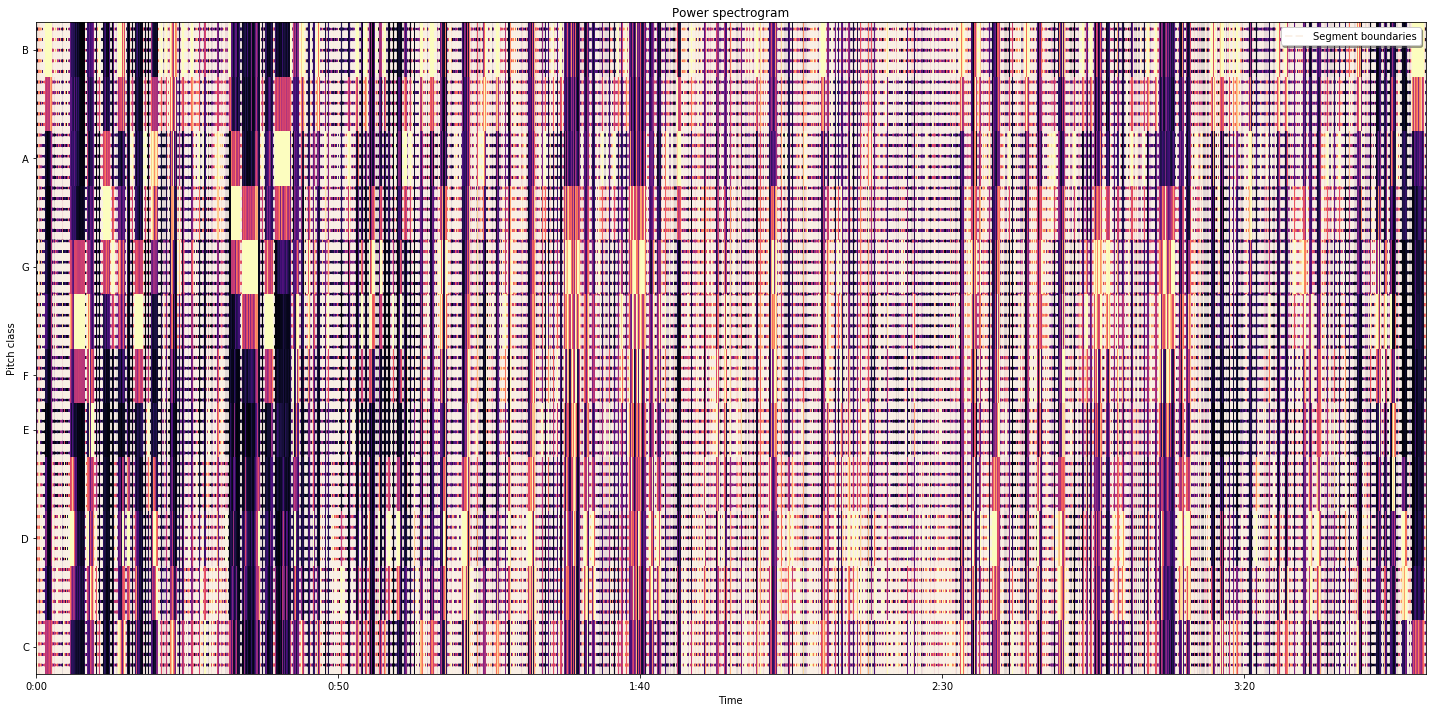

In [27]:
plt.figure(figsize=(20, 10))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.vlines(bound_times, 0, chromagram.shape[0], color='linen', linestyle='--', linewidth=2, alpha=0.9, label='Segment boundaries')
plt.axis('tight')
plt.legend(frameon=True, shadow=True)
plt.title('Power spectrogram')
plt.tight_layout()
plt.show()

In [119]:
# Use time-delay embedding to reduce noise
chroma_stack = librosa.feature.stack_memory(chromagram, n_steps=3)
# Build recurrence, suppress self-loops within 1 second
rec = librosa.segment.recurrence_matrix(chroma_stack, width=43,
                                        mode='affinity',
                                        metric='cosine')
# using infinite cost for gaps enforces strict path continuation
L_score, L_path = librosa.sequence.rqa(rec, np.inf, np.inf,
                                       knight_moves=True, backtrack=True)

---
## Use pychorus to identify verse/chorus structure in song

In [10]:
import sys

sys.path.append("../pychorus/")

import pychorus.helpers as pc
import pychorus.similarity_matrix as sm

In [21]:
chroma, y, sr, song_length_sec = pc.create_chroma("./2144 (Shut Up and Dance - bennydabeast)/song.ogg")

/opt/anaconda3/envs/BSmapsynth-env/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [72]:
chorus_list = pc.find_chorus(chroma, sr, song_length_sec, 10) #Line (start, end, lag)

In [73]:
chorus_list

[(Line (897 954 848), 6, 57),
 (Line (513 569 464), 4, 56),
 (Line (896 964 81), 3, 68),
 (Line (813 869 525), 3, 56),
 (Line (863 957 606), 2, 94),
 (Line (864 958 384), 1, 94),
 (Line (381 576 222), 0, 195),
 (Line (284 362 242), 0, 78),
 (Line (787 864 767), 0, 77)]

In [74]:
times = []
for x in chorus_list:
    start = (x[0].start / chroma_sr)
    end = (x[0].end / chroma_sr)
    times.append((start, end))

In [75]:
times.sort(key = lambda x: x[0])

In [76]:
times

[(52.71861629579099, 67.19767288407161),
 (70.72462256583228, 106.92226403653383),
 (95.22764140753794, 105.62286152220095),
 (146.0899683971391, 160.38339605480076),
 (150.91632059323265, 161.31154070789566),
 (160.19776712418178, 177.6468866023661),
 (160.38339605480076, 177.8325155329851),
 (166.3235218346082, 178.94628911669898),
 (166.50915076522716, 177.08999981050917)]

- Might want to use these times as a start for identifying song segments. Some overlap obviously, so maybe figure out a way to determine which parts overlap and combine into one segment.

In [ ]:
"Line ({} {} {})".format(self.start, self.end, self.lag)

In [24]:
time_time_similarity = sm.TimeTimeSimilarityMatrix(chroma, sr)

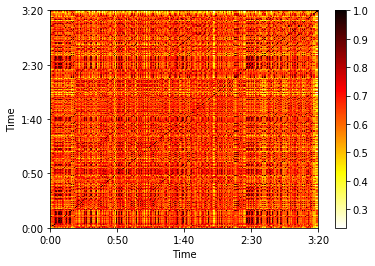

In [25]:
time_time_similarity.display()

In [77]:
time_lag_similarity = sm.TimeLagSimilarityMatrix(chroma, sr)

In [78]:
chroma_sr = chroma.shape[1] / song_length_sec
smoothing_size_samples = int(2.5 * chroma_sr)
time_lag_similarity.denoise(time_time_similarity.matrix,
                                smoothing_size_samples)

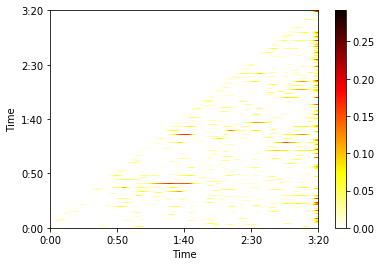

In [79]:
time_lag_similarity.display()